# 0

In [2]:
import pandas as pd
import json

train_path = "data/train.json"
test_path = "data/test.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open(test_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

print("Train dataset:", df_train.shape)
print(df_train.head(3))
print("\nTest dataset:", df_test.shape)
print(df_test.head(3))

Train dataset: (25000, 2)
                                                text  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1

Test dataset: (25000, 2)
                                                text  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_review(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package punkt to /home/corisco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/corisco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_train["clean_text"] = df_train["text"].apply(preprocess_review)
df_test["clean_text"] = df_test["text"].apply(preprocess_review)


# 1

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === Target Labels ===
y_train = df_train["label"]
y_test = df_test["label"]
X_train = df_train["clean_text"]
X_test = df_test["clean_text"]

# === Pipeline: CountVectorizer + MultinomialNB ===
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# === Extended Hyperparameter Grid ===
param_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "vectorizer__min_df": [1, 2, 3],
    "vectorizer__max_df": [0.9, 0.95],
    "classifier__alpha": [0.01, 0.1, 0.25, 0.5, 1.0]
}

# === Grid Search Setup ===
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1
)

# === Fit ===
print("[+] Starting grid search...")
grid_search.fit(X_train, y_train)
print("[+] Grid search completed.")

# === Results ===
best_model = grid_search.best_estimator_
print("[+] Best model parameters:", grid_search.best_params_)

# === Evaluation ===
y_pred = best_model.predict(X_test)
print("\n[+] Classification Report:\n", classification_report(y_test, y_pred))
print("[+] Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === Optional: Save the model
joblib.dump(best_model, "nb_final_model.joblib")
print("[+] Model saved to nb_final_model.joblib")


[+] Starting grid search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits


KeyboardInterrupt: 

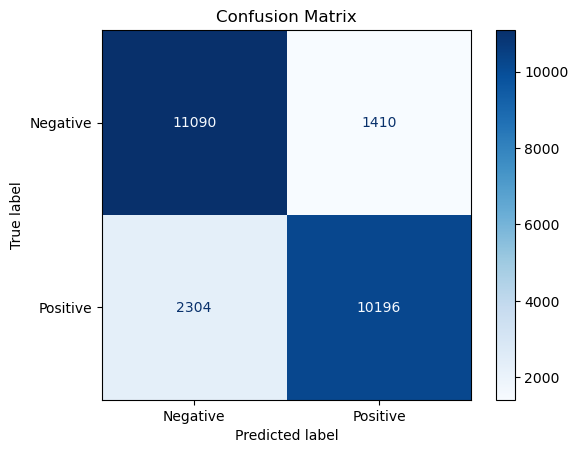

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib

# Save the full pipeline (vectorizer + classifier)
joblib.dump(best_model, "fail.joblib")
print("Model exported to skills_assessment.joblib")

Model exported to skills_assessment.joblib


# 2

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train = df_train["clean_text"]
y_train = df_train["label"]
X_test = df_test["clean_text"]
y_test = df_test["label"]

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
        sublinear_tf=True,           # Apply log-scaling to term frequency
        stop_words="english",        # Remove common English stop words
        ngram_range=(1, 2),          # Default, will be overridden by GridSearch
        min_df=1,                    # Default, will be overridden
        max_df=0.95                  # Static value
    )),
    ("classifier", LogisticRegression(
        max_iter=1000,
        solver="liblinear",          # Efficient for small/medium datasets
        penalty="l2"                 # Will test both l1/l2 via GridSearch
    ))
])

param_grid = {
    'classifier__C': [5, 10, 20],  # focus near best value
    'vectorizer__min_df': [1],     # 1 is consistently better
    'vectorizer__ngram_range': [(1, 1), (1, 2)]  # just to test simpler model
}



grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Start grid search
print("[*] Starting grid search with cross-validation...")

grid_search.fit(X_train, y_train)

# Output best parameters
print("\n[+] Grid search completed.")
print(f"[+] Best parameters found: {grid_search.best_params_}")

# Extract and store best estimator
best_model = grid_search.best_estimator_
print("[+] Best model pipeline stored.")

# Optionally evaluate on training set (quick check)
train_accuracy = best_model.score(X_train, y_train)
print(f"[+] Training accuracy: {train_accuracy:.4f}")

# Predict and evaluate on test set
print("\n[*] Evaluating on test data...")
y_pred = best_model.predict(X_test)
print("\n[+] Classification Report:")
print(classification_report(y_test, y_pred))


[*] Starting grid search with cross-validation...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__C=5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.7s
[CV] END classifier__C=5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.7s
[CV] END classifier__C=5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.8s
[CV] END classifier__C=5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.9s
[CV] END classifier__C=5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.9s
[CV] END classifier__C=10, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   3.9s
[CV] END classifier__C=10, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   4.0s
[CV] END classifier__C=10, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   4.1s
[CV] END classifier__C=10, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1); total time=   

In [30]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Reuse preprocessed train/test sets and labels
X_train = df_train["clean_text"]
y_train = df_train["label"]
X_test = df_test["clean_text"]
y_test = df_test["label"]

# Best pipeline configuration based on previous grid search
best_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 2), min_df=1)),
    ("classifier", LogisticRegression(C=10, max_iter=1000))
])

# Train the best model directly
print("[*] Training final model...")
best_pipeline.fit(X_train, y_train)
print("[+] Training completed.")

# Save model
joblib.dump(best_pipeline, "skills_assessment.joblib")
print("[+] Model saved as skills_assessment.joblib")

# Evaluate on test set
print("\n[*] Evaluating on test data...")
y_pred = best_pipeline.predict(X_test)
print("\n[+] Classification Report:")
print(classification_report(y_test, y_pred))


[*] Training final model...
[+] Training completed.
[+] Model saved as skills_assessment.joblib

[*] Evaluating on test data...

[+] Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



# 3